# Example notebook: Spliced Binned-Pareto distribution fitted using a distributional neural network

This notebook is an example how to
(a) use a distributional neural network to fit a Spliced Binned-Pareto distribution to given data, and 
(b) compare the Spliced Binned-Pareto distribution fit to other distributions' fits. This notebook was built was Python v3.7.9 and GluonTS v0.10.4.

1. [Library imports](#imports)
1. [Data generation](#data)
1. [Train a Distributional neural network](#tcn)
    1. (new) Spliced Binned-Pareto distribution
    1. Gaussian distribution
1. [Evaluation: Probability-Probability plots on test data](#pp)



<div style="text-align: right"> Total Runtime (1 cpu): 10 minutes </div>




## Library Imports <a name="imports"></a>

In [2]:
# %matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pydantic import PositiveFloat, PositiveInt
import numpy as np
import os
import pprint
import random
from scipy import stats 
from scipy.special import softmax
import time
from tqdm import tqdm, trange
from typing import List, Tuple, Optional


import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader

from gluonts.torch.distributions.distribution_output import (
    Distribution,
    DistributionOutput,
    Normal,
    NormalOutput,
)

from gluonts.torch.distributions.binned_uniforms import (
    BinnedUniforms,
    BinnedUniformsOutput,
)

from gluonts.torch.distributions.spliced_binned_pareto import (
    SplicedBinnedPareto,
    SplicedBinnedParetoOutput,
)

from gluonts.nursery.spliced_binned_pareto.training_functions import (
    plot_prediction,
    highlight_min,
)
from gluonts.nursery.spliced_binned_pareto.data_functions import create_ds, create_ds_asymmetric


font = {"family": "serif", "weight": "normal", "size": 12}
matplotlib.rc("font", **font)


###########################
# Get device information
###########################
cuda_id = "0"
if torch.cuda.is_available():
    dev = f"cuda:{cuda_id}"
else:
    dev = "cpu"
device = torch.device(dev)
print("Device is", device)



# Reproducibility
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

Device is cuda:0


## Data Generation <a name="data"></a>

Here we generate time series with a sinusoidal mean, and asymmetric heavy-tailed noise.

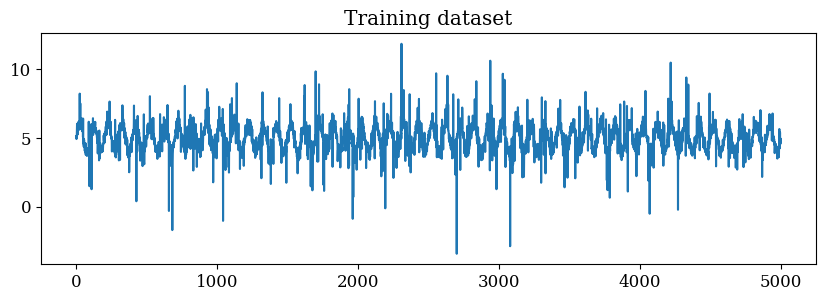

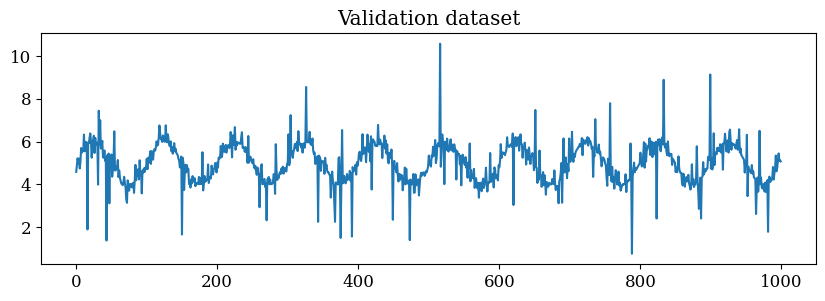

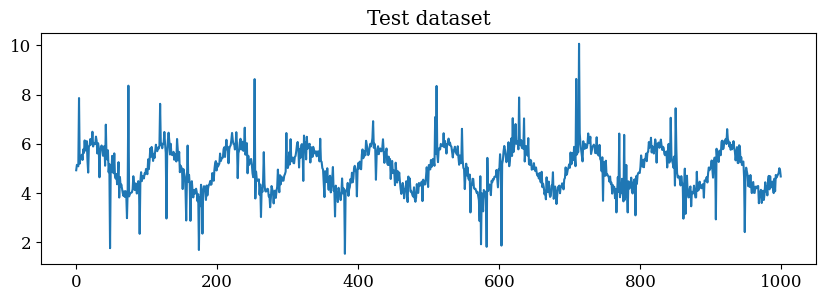

In [9]:
t_dof = [10, 10]
noise_mult = [0.25, 0.25]
xi = [1 / 50.0, 1 / 25.0]

train_ts_tensor = create_ds_asymmetric(5_000, t_dof, noise_mult, xi).squeeze().squeeze()
val_ts_tensor = create_ds_asymmetric(1_000, t_dof, noise_mult, xi).squeeze().squeeze()
test_ts_tensor = create_ds_asymmetric(1_000, t_dof, noise_mult, xi).squeeze().squeeze()

train_ts_tensor = train_ts_tensor.to(device)
val_ts_tensor = val_ts_tensor.to(device)
test_ts_tensor = test_ts_tensor.to(device)

plt.figure(figsize=(10, 3))
plt.plot(train_ts_tensor.cpu().flatten())
plt.title("Training dataset")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(val_ts_tensor.cpu().flatten())
plt.title("Validation dataset")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(test_ts_tensor.cpu().flatten())
plt.title("Test dataset")
plt.show()

## Train a Distributional Neural Network <a name="tcn"></a>

Here we design a DistributionOutput Neural Network (DistributionalOutputNN) to learn the one-step ahead (lead_time) predictive distribution from the series' previous 100 observations (context_length). We use the DistributionalOutputNN to compare the fits of predictive distributions: Spliced Binned-Pareto, and Gaussian.

| Distribution      | Avg Time | Approx Total Time (1 cpu) | 
| ----------- | ----------- | ----------- |
| Spliced Binned-Pareto      | 0.76s/epoch       | 4 min       |
| Gaussian   | 0.5s/epoch        | 2.5 min       |

In [10]:
context_length = 100
lead_time = 1

# Defining the main hyperparameters
bins_upper_bound = train_ts_tensor.max()
bins_lower_bound = train_ts_tensor.min()
nbins = 100
percentile_tail = 0.05

In [15]:
class WindowDataset(Dataset): 
    """
    Creates inputs of window size context_length, corresponding to outputs of lead_time ahead
    * where both are on the same device
    """
    
    def __init__(self, y, context_length=100, lead_time=1, device=device):
        self.y = y[context_length:].double()
        self.x = y[:-lead_time].double()
        self.device = device
        self.context_length = context_length
        self.lead_time = lead_time

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index:(context_length+index)].to(self.device), self.y[index].to(self.device)
    
    
# Super simple model for Marginal Distribution:
def append_layer(
    l_layers: List,
    input_dimension: int,
    output_dimension: int,
    dropout_probability: PositiveFloat = PositiveFloat(0.25),
):
    linear = torch.nn.Linear(input_dimension, output_dimension)
    l_layers.append(linear)
        
    l_layers.append(torch.nn.Dropout(dropout_probability))
    l_layers.append(torch.nn.LeakyReLU())
    return l_layers


class DistributionOutputNN(torch.nn.Module):
    """
    This neural net's forward specifies (or updates) the parameter estimates of the given DistributionOutput
    """
    def __init__(
        self,
            input_dimension: int = 1, # Dimension of input data
        number_hidden_layers: int = 10,
        number_hidden_dimensions: int = 30,
        distr_output: DistributionOutput = NormalOutput(),
        init_args: Optional[Tuple] = None,
        verbose=False,
    ):
        super().__init__()
        
        # The number of parameters to fit
        self.distr_output = distr_output
        self.output_dimension = len(self.distr_output.args_dim)
        
        ###  Creating the main network:
        net_layers = []
        
        dropout_probability = 0.5
        dropout_probability_per_layer = np.linspace(start=dropout_probability, stop=0.0, num=number_hidden_layers)
        if number_hidden_layers > 1:
            dropout_probability_per_layer[-2] = 0.0
        
        # We add the first layer:
        net_layers = append_layer(net_layers, input_dimension, number_hidden_dimensions, dropout_probability)
        
        # We add each of the hidden layers:
        for i in range(number_hidden_layers - 1):
            net_layers = append_layer(net_layers, number_hidden_dimensions, number_hidden_dimensions, dropout_probability_per_layer[i])
            
        # We add the final layer:
        net_layers.append(torch.nn.Linear(number_hidden_dimensions, self.output_dimension))

        # The network
        self.network = torch.nn.Sequential( *net_layers )
        
        # Reserve for specifying the distribution fit
        self.args_proj = distr_output.get_args_proj(self.output_dimension)
        if init_args is not None:
            assert (
                len(init_args)==self.output_dimension
            ), f"len(init_args) should equal self.output_dimension but {len(init_args)} != {self.output_dimension}"
            self.distr_args = init_args
            self.distr = self.distr_output.distribution(init_args)
        else:
            self.distr_args = None
            self.distr = None
    
    def forward(self, x):
        net_out = self.network(x)
        net_out_final = net_out.squeeze() # has shape: *batch_size,output_dimension
        
        self.distr_args = self.args_proj(net_out_final)
        self.distr = self.distr_output.distribution(self.distr_args)
        
        return self.distr   
    
def print_model_param_values(model):
    distr_parameter_names = list(model.distr_output.args_dim.keys())
    for i in range(len(distr_parameter_names)):
        try:
            npvalue = model.distr_output.distribution(model.distr_args).__getattribute__(distr_parameter_names[i]).detach().cpu().numpy()
            print(distr_parameter_names[i], npvalue[0])
        except:
            print(distr_parameter_names[i], "NoneType")

    
def train_NN_with_log_prob(
    model: DistributionOutputNN,
    training_x: torch.tensor,
    learning_rate: float = 0.0005,
    weight_decay: PositiveFloat = PositiveFloat(1e-3),
    batch_size: int = 100,
    epochs: int = 50,
    validation_x: Optional[torch.tensor] = None,
) -> Distribution:
    """
    This trains a Distribution Neural Net with respect to the negative log-likelihood of its DistributionOutput
    """
    
    # Get the model parameters:
    model.to(device)
    model = model.double()
    params = list(model.parameters())
    
    ## Check that model is being updated
    #print_model_param_values(model)
    
    train_losses = []
    val_losses = []
    predictions_list = []

    optimizer = optim.Adam(params=params, lr=learning_rate, weight_decay=weight_decay)
    epoch_mod = 25
    
    # Training loop:
    t = trange(epochs, desc=f"[{title_method}]", leave=True)
    for epoch in t:

        wd_train = WindowDataset(training_x)
        loader_train = iter(DataLoader(wd_train, batch_size=batch_size, shuffle=False))
        loader_val = iter(DataLoader(WindowDataset(validation_x), batch_size=batch_size, shuffle=False))
        
        #######################################
        # Train over all the batches:
        #######################################
        model.train()

        batch_losses = []
        for i in range(0, (len(training_x)-context_length) // batch_size):

            # Get the training examples:
            input_features, output_y = next(loader_train)

            # Compute Neg-Loglikelihood
            fitted_distr = model(input_features)
            losses = -1 * fitted_distr.log_prob(output_y)

            # Back-propagate the loss
            loss = torch.mean(losses)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_losses.append(loss.item())
            
            ## Check that model is being updated
            #print_model_param_values(model)

        epoch_train_loss = np.mean(batch_losses)
        train_losses.append(epoch_train_loss)
        
        predictions = {
            "low_lower": [],
            "lower": [],
            "median": [],
            "upper": [],
            "up_upper": [],
        }
        
        if (epoch % epoch_mod == 0) and (validation_x is not None): 
            model.eval()
            batch_val_losses = []
            for i in range(0, (len(validation_x)-context_length) // batch_size):

                # Get the training examples:
                input_features, output_y = loader_val.next()

                # Compute Neg-Loglikelihood
                fitted_distr = model(input_features)
                losses = -1 * fitted_distr.log_prob(output_y)

                # Validation loss
                loss = torch.mean(losses)
                batch_val_losses.append(loss.item())
                
                # Validation predictions
                predictions["lower"].append(fitted_distr.icdf(torch.tensor(0.05, device=device)).detach().cpu().numpy())
                predictions["median"].append(fitted_distr.icdf(torch.tensor(0.5, device=device)).detach().cpu().numpy())
                predictions["upper"].append(fitted_distr.icdf(torch.tensor(0.95, device=device)).detach().cpu().numpy())
                predictions["low_lower"].append(fitted_distr.icdf(torch.tensor(0.01, device=device)).detach().cpu().numpy())
                predictions["up_upper"].append(fitted_distr.icdf(torch.tensor(0.99, device=device)).detach().cpu().numpy())
            
            
            epoch_val_loss = np.mean(batch_val_losses)
            val_losses.append(epoch_val_loss)
            predictions["lower"] = np.array(predictions["lower"]).flatten()
            predictions["median"] = np.array(predictions["median"]).flatten()
            predictions["upper"] = np.array(predictions["upper"]).flatten()
            predictions["low_lower"] = np.array(predictions["low_lower"]).flatten()
            predictions["up_upper"] = np.array(predictions["up_upper"]).flatten()
            predictions_list.append(predictions)
            
#             ####################################################################################
#             # Plot of intermediary distribution fit on validation data
#             ####################################################################################
#             #f_ax2 = fig.add_subplot(spec[0, 1:])
#             fig = plot_prediction(
#                 validation_x,
#                 predictions_list[-1],
#                 context_length,
#                 lead_time,
#                 start=0,
#                 end=len(validation_x),
#                 #fig=None,
#             )
#             title = plt.gca().get_title()  #MAE
#             plt.ylim(-5.0, 30.0)
#             plt.xlabel(f"Time increment $t$")
#             plt.ylabel(r"Series values")
#             plt.ylim(-5.0, 30.0)
#             title = title_method + " validation MAE: " + str(np.round(np.float64(title),3)) + f", epoch: {epoch}"
#             plt.title(title)
#             plt.show()
        

    ####################################################################################
    # Plot losses
    ####################################################################################
    fig = plt.figure(figsize=[16, 4])
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)

    f_ax1 = fig.add_subplot(spec[0, 0])
    plt.plot(train_losses, label="Training")
    if validation_x is not None:
        plt.plot(
            epoch_mod + epoch_mod * np.arange(len(val_losses)),
            [i for i in val_losses],
            label="Validation",
        )
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_method} DistributionalNN")
    
    ####################################################################################
    # Plot of distribution fit on validation data
    ####################################################################################
    f_ax2 = fig.add_subplot(spec[0, 1:])
    fig = plot_prediction(
        validation_x,
        predictions_list[-1],
        context_length,
        lead_time,
        start=0,
        end=len(validation_x),
        fig=f_ax2,
    )
    title = plt.gca().get_title() #MAE
    plt.ylim(-5.0, 30.0)
    plt.xlabel(f"Time increment $t$")
    plt.ylabel(r"Series values")
    plt.ylim(-5.0, 30.0)
    title = title_method + " validation MAE: " + title
    plt.title(title)
    plt.show()
        
    return fitted_distr


In [17]:
title_methods = ["gaussian"]

dict_storage = dict(
    zip(
        list(
            map(
                lambda x: x.lower().replace(" ", "").replace("-", ""),
                title_methods
            )
        ),
        list(
            map(
                lambda title_method: dict({}), 
                title_methods
            )
        ),
    )
)


for title_method in title_methods:
    method_str = title_method.lower().replace(" ", "").replace("-", "")

    ####################################################################################
    # Specifying the predictive output distribution
    ####################################################################################
    if method_str == "splicedbinnedpareto":

        spliced_binned_pareto_distr = SplicedBinnedParetoOutput(
            bins_lower_bound=bins_lower_bound, 
            bins_upper_bound=bins_upper_bound, 
            num_bins=nbins, 
            tail_percentile_gen_pareto=percentile_tail
        )
        output_distribution = spliced_binned_pareto_distr
        learning_rate = 0.0003

    if method_str == "gaussian":

        gaussian_distr = NormalOutput()
        output_distribution = gaussian_distr
        learning_rate = 0.0002
        



    ####################################################################################
    # Creating the Distributional Neural Net
    ####################################################################################
    model = DistributionOutputNN(
        input_dimension = context_length, # Dimension of input data
        number_hidden_layers = 10,
        number_hidden_dimensions = 30, 
        distr_output = output_distribution,
    )

    ####################################################################################
    # Training TCN for predictive distribution:
    ####################################################################################
    epochs = 300
    batch_size = 32

    dict_storage[method_str] = dict(
        (
            (k, eval(k))
            for k in (
                "method_str",
                "title_method",
                "learning_rate",
                "epochs",
                "context_length",
                "lead_time",
            )
        )
    )

    ####################################################################################
    # Train model
    # Running a Distributional NN on data
    # Maximum Likelihood Estimation on the DistributionOutput
    ####################################################################################
    start = time.time()

    distr_hat = train_NN_with_log_prob(
                    model, 
                    train_ts_tensor,
                    learning_rate=learning_rate,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_x = val_ts_tensor,
                )


    end = time.time()
    print("runtime:", end - start)
    dict_storage[method_str]["runtime"] = end - start
    dict_storage[method_str]["model"] = model
    

[gaussian]:   0%|          | 0/300 [00:00<?, ?it/s]

[gaussian]:   0%|          | 0/300 [1:39:57<?, ?it/s]


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

## Evaluation: Probability-Probability plots on test data <a name="pp"></a>

We evaluate the accuracy of the density estimation of each of the method using Probability-Probability (PP) plots (PP-plots). For a given quantile level $q$, we compute $ y_q$ the fraction of points that fell below the given quantile $z_q{(t)} $ of their corresponding predictive distribution:
\begin{align}
  y_q = \frac{\sum_{t=2}^{T} \mathbb{I}[ {x}_t < z_{1-q}{(t)} ] }{T}, \hspace{40pt}   z_q{(t)} : p\left( {x}_{t} > z_q{(t)} \middle| {x}_{1:t-1} \right)< q
\end{align}
To obtain a quantitative score, we measure how good the tail estimate is by computing the Mean Absolute Error (MAE) between  $y_q $ and $q $ for all measured quantiles $q$.



In [ ]:
def quantile_to_str(q):
    """
    Quick function to cast quantile decimal to q-prefixed string
    """
    return "q-" + str(np.round(q, 3))


lower_tail_end = percentile_tail
upper_tail_start = 1 - percentile_tail

likelihoods_of_interest = np.linspace(0.001, lower_tail_end, 25)
quantile_levels = torch.tensor(
    np.unique(
        np.round(
            np.concatenate(
                (
                    likelihoods_of_interest,
                    np.linspace(lower_tail_end, upper_tail_start, 81),
                    1 - likelihoods_of_interest,
                )
            ),
            3,
        )
    )
)
quantile_strs = list(map(quantile_to_str, quantile_levels.numpy()))
quantile_levels = quantile_levels.to(torch.device(dev))

ts_out_tensor = test_ts_tensor.float()
ts_len = ts_out_tensor.shape[-1]
data_out = dict(
    time=np.arange(ts_out_tensor.shape[-1] + lead_time),
    ts=np.concatenate(
        (ts_out_tensor.cpu().squeeze(), np.array([np.nan] * lead_time))
    ),
)

for method_str in list(dict_storage.keys()):
    print('method_str', method_str)

    # Get the stored DistributionNN fitted for the given method
    model = dict_storage[method_str]["model"]
    title_method = dict_storage[method_str]["title_method"]

    data_out[method_str] = dict()
    for q_str in quantile_strs:
        data_out[method_str][q_str] = [np.nan] * (context_length + 2)

        
    # Loop through the time series
    loader_test = iter(DataLoader(WindowDataset(ts_out_tensor), batch_size=(ts_len - context_length), shuffle=False))
    start = time.time()
    for i in trange(1):#t:

        input_features, output = loader_test.next()
        distr_output = model(input_features)

        # z_q(t) quantile of predictive distribution
        for qs, ql in zip(quantile_strs, quantile_levels):
            qv = distr_output.icdf(ql)
            data_out[method_str][qs] = np.concatenate([data_out[method_str][qs], qv.detach().cpu().numpy()])



    # y_q fraction of points below z_q(t)
    calibration_pairs = []
    for qs, ql in zip(quantile_strs, quantile_levels.cpu().numpy()):
        proportion_observations = np.array(
            list(
                map(
                    lambda x: x[0] < x[1],
                    zip(data_out["ts"], data_out[method_str][qs]),
                )
            )
        ).sum() / np.sum(np.isfinite(np.array(data_out[method_str][qs])))
        calibration_pairs.append([ql, proportion_observations])
    calibration_pairs = np.array(calibration_pairs)
    data_out[method_str]["calibration"] = calibration_pairs

In [ ]:
fig = plt.figure(figsize=[15, 5], constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
mae_table = pd.DataFrame(
    [],
    columns=["Lower tail", "Base", "Upper tail", "Full distribution"],
    index=title_methods,
)

# Lower tail
start = 0.0
end = lower_tail_end
indices = quantile_levels.cpu().numpy() > start
indices *= quantile_levels.cpu().numpy() < end

f_ax1 = fig.add_subplot(spec[0, 0])
alpha = 0.5
plt.plot(
    np.linspace(start, end),
    np.linspace(start, end),
    color="gray",
    alpha=alpha,
    label=None,
)
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]["calibration"]
    mae = np.mean(np.abs(np.diff(calibration_pairs[indices, :])))
    title_method = dict_storage[method_str]["title_method"]
    mae_table.loc[title_method, "Lower tail"] = mae
    plt.scatter(
        calibration_pairs[indices, 0],
        calibration_pairs[indices, 1],
        label=f"{title_method} {np.round(mae,3)}",
    )
plt.legend(title="MAE")
plt.xlabel(f"CDF of fitted distribution")
plt.ylabel("Empirical CDF")
# Proportion of data below quantile');
plt.title("Lower tail PP-plot")

# Base distribution
start = lower_tail_end
end = upper_tail_start
indices = quantile_levels.cpu().numpy() > start
indices *= quantile_levels.cpu().numpy() < end

f_ax1 = fig.add_subplot(spec[0, 1])
alpha = 0.5
plt.plot(
    np.linspace(start, end),
    np.linspace(start, end),
    color="gray",
    alpha=alpha,
    label=None,
)
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]["calibration"]
    mae = np.mean(np.abs(np.diff(calibration_pairs[indices, :])))
    title_method = dict_storage[method_str]["title_method"]
    mae_table.loc[title_method, "Base"] = mae
    plt.scatter(
        calibration_pairs[indices, 0],
        calibration_pairs[indices, 1],
        alpha=alpha,
        label=f"{title_method} {np.round(mae,2)}",
    )
plt.legend(title="MAE")
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot(
    [xlim[0], lower_tail_end, lower_tail_end],
    [lower_tail_end, lower_tail_end, ylim[0]],
    color="black",
    label=None,
)
plt.text(0.02, lower_tail_end, "Lower\n tail", ha="center", va="bottom")
plt.plot(
    [upper_tail_start, upper_tail_start, xlim[1]],
    [ylim[1], upper_tail_start, upper_tail_start],
    color="black",
    label=None,
)
plt.text(
    (xlim[1] - upper_tail_start) / 2 + upper_tail_start,
    upper_tail_start - 0.03,
    "Upper\n tail",
    ha="center",
    va="top",
)
plt.xlabel(f"CDF of fitted distribution")
plt.title("Base PP-plot")


# Upper tail
start = upper_tail_start
end = 1
indices = quantile_levels.cpu().numpy() > start
indices *= quantile_levels.cpu().numpy() < end

f_ax2 = fig.add_subplot(spec[0, 2])
plt.plot(
    np.linspace(start, end),
    np.linspace(start, end),
    color="gray",
    alpha=alpha,
    label=None,
)
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]["calibration"]
    mae = np.mean(np.abs(np.diff(calibration_pairs[indices, :])))
    title_method = dict_storage[method_str]["title_method"]
    mae_table.loc[title_method, "Upper tail"] = mae
    plt.scatter(
        calibration_pairs[indices, 0],
        calibration_pairs[indices, 1],
        label=f"{title_method} {np.round(mae,3)}",
    )
plt.legend(title="MAE")
plt.xlabel(f"CDF of fitted distribution")
plt.title("Upper tail PP-plot")
# plt.show()


# Full distribution
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]["calibration"]
    mae = np.mean(np.abs(np.diff(calibration_pairs)))
    title_method = dict_storage[method_str]["title_method"]
    mae_table.loc[title_method, "Full distribution"] = mae

from IPython.display import Image
from IPython.core.display import Image, display


# Highlight the method row that achieves the minimum error for each column
display(
    mae_table.style.set_caption("Mean Absolute Error (MAE)")
    .set_table_styles(
        [{"selector": "caption", "props": [("font-size", "16px")]}]
    )
    .apply(highlight_min)
)
print("\n\n\n")